## Table des matières

- [Présentation des données](#Intro)
- [1. Correction des données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire](#chapitre_1)
- [2. Désaisonnalisation de la consommation obtenue après correction, grâce aux moyennes mobiles](#chapitre_2)
- [3. Prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temportelle](#chapitre_3)

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

<a id="Intro"></a>
## <span style="color: #030aa4">Présentation des données</span>

Les données mensuelles de consommation d'électricité en énergie proviennent du site https://www.rte-france.com/eco2mix/telecharger-les-indicateurs

In [2]:
DonneesMensuelles = pd.read_csv("eCO2mix_RTE_energie_M.csv", sep='\t')

DonneesMensuelles.head(3)

,Mois,Qualite,Territoire,Production totale,Production nucleaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioenergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01,Donnees definitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
1,2012-02,Donnees definitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2,2012-03,Donnees definitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0


In [3]:
DonneesMensuelles.columns

Index(['Mois', 'Qualite', 'Territoire', 'Production totale',
       'Production nucleaire', 'Production thermique totale',
       'Production thermique charbon', 'Production thermique fioul',
       'Production thermique gaz', 'Production hydraulique',
       'Production eolien', 'Production solaire', 'Production bioenergies',
       'Consommation totale', 'Solde exportateur', 'Echanges export',
       'Echanges import', 'Echanges avec le Royaume-Uni',
       'Echanges avec l'Espagne', 'Echanges avec l'Italie',
       'Echanges avec la Suisse', 'Echanges avec l'Allemagne et la Belgique'],
      dtype='object')

Le dataframe se compose de 22 colonnes :
- Mois : indique le mois analysé
- Qualite : trois types de données : temps réel, consolidées et définitives. Données temps réel disponibles 30 jours, puis remplacées par données consolidées. Données consolidées remplacées par donées définitives l'année suivante
- Territoire : indique le territoire concerné. Choix entre la France et une des 12 régions administratives.
- Production totale :  production totale d'électricité en MW
- Production nucléaire/thermique totale/thermique charbon/thermique fioul/thermique gaz/hydraulique/eolien/solaire/bioenergies : indique la quantité de production d'électricité produite en MW selon la source de production 
- Consommation totale : consommation totale d'électricité en MW
- Solde exportateur : somme des quantités d'électricité en MW importées et exportées
- Echanges exports : quantité d'électricité en MW exportée
- Echanges imports : quantité d'électricité en MW importée
- Echanges avec R-U/Espagne/Italie/Suisse/Allemagne et Belgique : détails des échanges avec chaque pays indiqué

Source des informations : https://assets.rte-france.com/prod/public/2020-07/%C3%A9CO2mix%20-%20Description%20des%20fichiers%20des%20donn%C3%A9es%20en%20puissance.pdf

Les données de l'effet température proviennent du site https://cegibat.grdf.fr/simulateur/calcul-dju 

In [4]:
Dju_chauffage = pd.read_csv('dju_chauffage.csv')

Dju_chauffage

,Unnamed: 0,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,TOTAL
0,2010,624.8,474.7,414.9,292.7,260.6,112.6,46.5,93.8,163.6,286.4,419.3,644.1,3833.8
1,2011,507.2,408.6,368.7,202.0,165.6,117.2,122.5,84.7,101.9,232.3,338.0,424.8,3073.4
2,2012,454.5,555.6,334.9,344.4,192.8,133.3,95.3,59.6,165.5,262.1,403.3,455.7,3456.9
3,2013,548.2,519.7,505.5,326.3,277.4,146.0,51.3,79.0,141.8,209.3,417.7,456.5,3678.6
4,2014,434.4,376.9,346.9,255.1,219.7,124.4,76.3,104.9,111.9,194.5,326.6,489.2,3060.6
5,2015,507.0,472.3,400.2,269.9,210.1,109.2,62.7,61.0,184.6,293.5,301.0,349.1,3220.5
6,2016,477.6,428.8,445.1,333.6,207.6,117.4,66.3,61.3,85.7,290.2,400.3,511.6,3425.4
7,2017,592.6,382.6,318.9,315.3,168.7,72.8,59.2,74.7,158.1,206.1,392.9,483.4,3225.2
8,2018,417.9,537.6,426.6,224.3,163.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


Le jeu de données 'Dju_chauffage' est composée de 14 colonnes et 9 lignes. 12 de ces colonnes indiquent le degré jour unifié pour chaque mois de l'année. la première colonne nous indique l'année concernée et la dernière le total annuel. Chaque ligne correspond à une année pour la période allant de 2010 à 2018.

Le degré jour est une valeur représentative de l’écart entre la température d’une journée donnée et un seuil de température préétabli (18 °C dans le cas des DJU ou Degré Jour Unifié). Sommés sur une période, ils permettent de calculer les besoins de chauffage d’un bâtiment.
    
Source : https://cegibat.grdf.fr/simulateur/calcul-dju

<a id="chapitre_1"></a>
## <span style="color: #030aa4">1. Correction des données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire</span>

In [5]:
data = DonneesMensuelles.loc[:,('Mois','Territoire','Consommation totale')]
data = data[data.Territoire=='France']
data = data.rename(columns={'Consommation totale':'consommation_totale_France'})\
           .drop(columns='Territoire')

data['Mois'] = pd.to_datetime(data['Mois'], infer_datetime_format=True)

data_chauffage = Dju_chauffage[Dju_chauffage['Unnamed: 0']!=2010]
data_chauffage = data_chauffage[data_chauffage['Unnamed: 0']!=2011]
data_chauffage = data_chauffage.drop(columns='TOTAL')\
                               .rename(columns={'JAN':'01','FÉV':'02','MAR':'03','AVR':'04','MAI':'05','JUN':'06','JUI':'07','AOÛ':'08','SEP':'09','OCT':'10','NOV':'11','DÉC':'12'})\
                               .melt('Unnamed: 0', var_name= 'Année', value_name='DJU')\
                               .rename(columns={'Unnamed: 0':'year','Année':'month'})

data_chauffage['Mois'] = pd.to_datetime(data_chauffage[['year', 'month']].assign(DAY=1))

data_chauffage = data_chauffage.drop(columns=['year','month'])

data = pd.merge(data,data_chauffage)

data.head(3)

,Mois,consommation_totale_France,DJU
0,2012-01-01,51086,454.5
1,2012-02-01,54476,555.6
2,2012-03-01,43156,334.9


**Vérification des données :**

In [6]:
data.describe()

,consommation_totale_France,DJU
count,84.000000,84.000000
mean,40109.726190,259.967857
std,7135.547804,170.458225
min,31004.000000,0.000000
25%,33696.750000,108.125000
50%,37082.500000,258.600000
75%,45914.250000,406.900000
max,57406.000000,592.600000


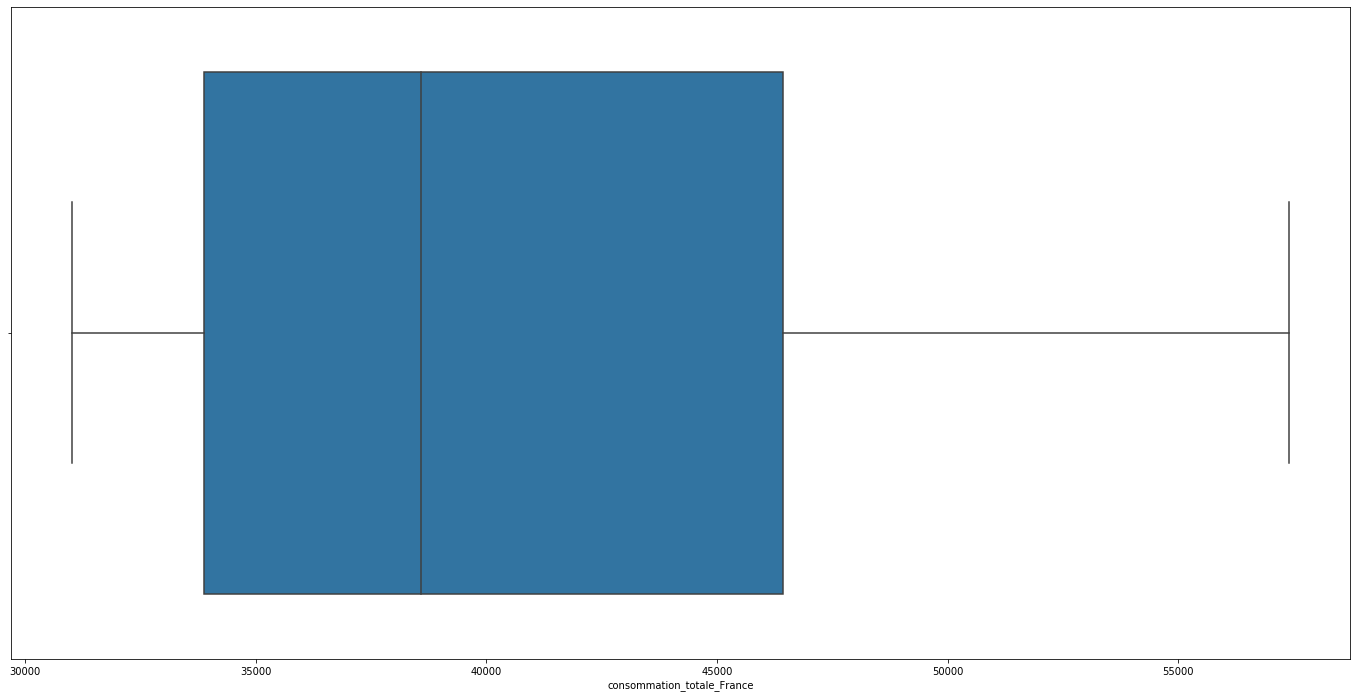

In [43]:
sns.boxplot(x=data['consommation_totale_France'], data=data, orient='h')

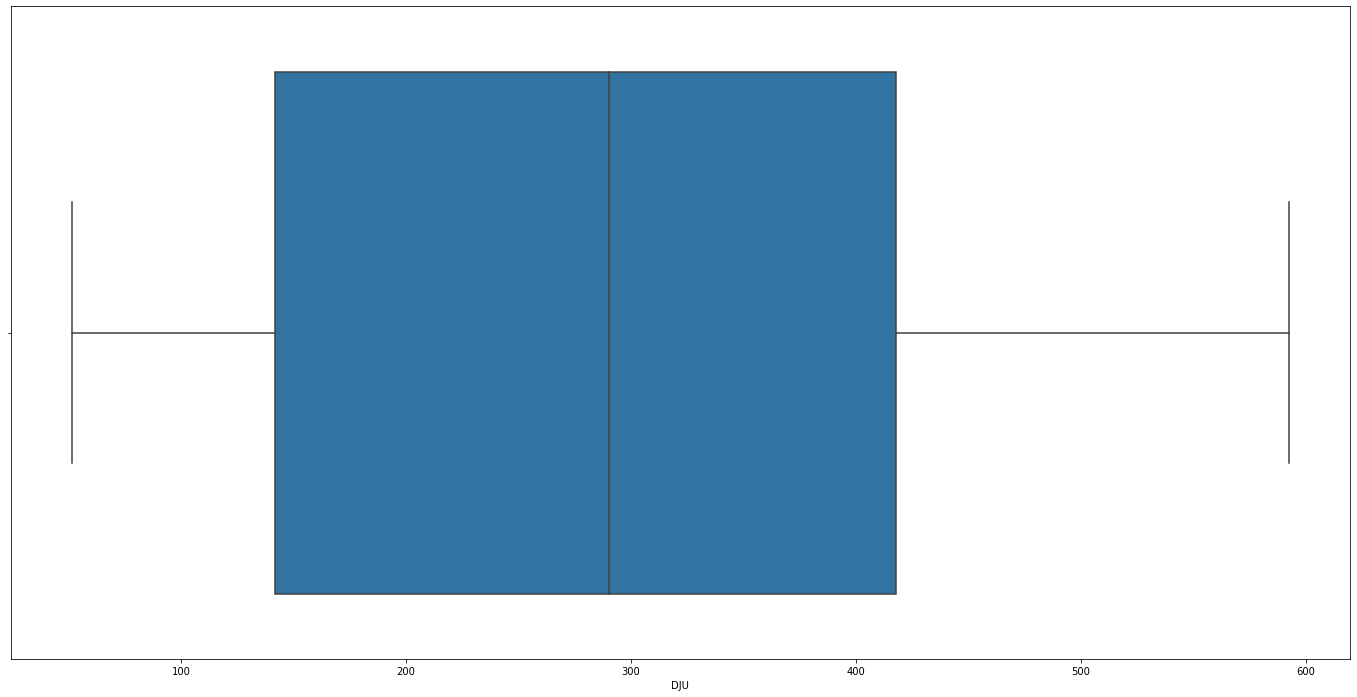

In [44]:
sns.boxplot(x=data['DJU'], data=data, orient='h')

Il n'y a pas de valeurs aberrantes.

In [7]:
data[data.isna().any(axis=1)].shape[0]

0

Il n'y a aucune valeur manquante.

Les données des DJU s'arrêtent à mai 2018 :

In [8]:
data.tail(10)

,Mois,consommation_totale_France,DJU
74,2018-03-01,48493,426.6
75,2018-04-01,36276,224.3
76,2018-05-01,33994,163.0
77,2018-06-01,32614,0.0
78,2018-07-01,34602,0.0
79,2018-08-01,32451,0.0
80,2018-09-01,32683,0.0
81,2018-10-01,37102,0.0
82,2018-11-01,43738,0.0
83,2018-12-01,47553,0.0


Aussi, afin de ne pas fausser l'analyse, les données utilisées n'iront pas au-delà de cette date.

In [9]:
data = data[data.DJU!=0]

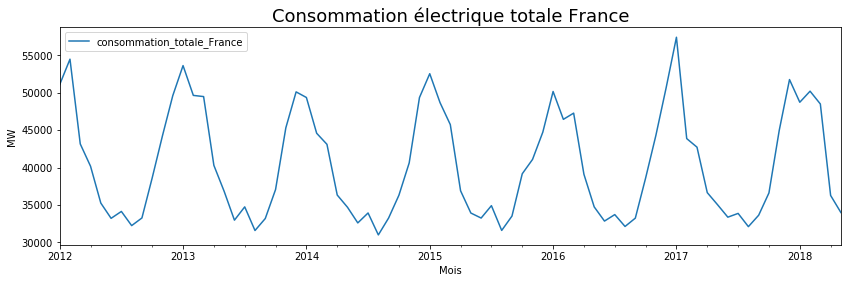

In [10]:
data.plot(x='Mois',y="consommation_totale_France", figsize=(14,4))
plt.title("Consommation électrique totale France", fontsize=18)
plt.ylabel('MW')
plt.savefig('01.Conso_totale_France.png')

L'écart entre la valeur la plus faible et celle la plus élevée pour chaque période semble constant. **Il s'agit d'un modèle additif.** Nous n'avons donc pas besoin de convertir les données en logarithme.

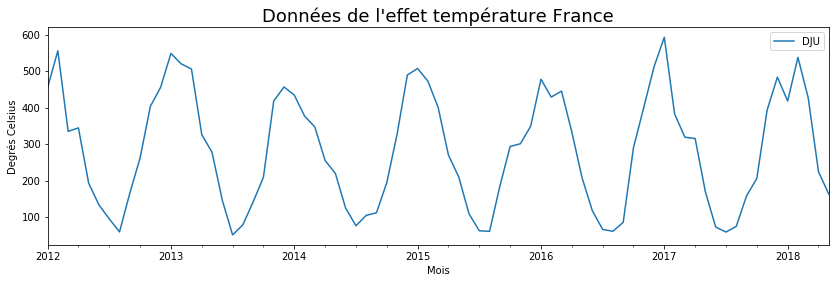

In [11]:
data.plot(x='Mois',y="DJU", figsize=(14,4))
plt.title("Données de l'effet température France", fontsize=18)
plt.ylabel('Degrés Celsius')
plt.savefig('02.Donnees_Effet_Temperature.png')

**Régression linéaire avec pour variable explicative les degrés jour unifiés :**

In [12]:
import statsmodels.formula.api as smf

reg_Conso = smf.ols('consommation_totale_France~DJU', data=data).fit()
print(reg_Conso.summary())

                                OLS Regression Results                                
Dep. Variable:     consommation_totale_France   R-squared:                       0.925
Model:                                    OLS   Adj. R-squared:                  0.924
Method:                         Least Squares   F-statistic:                     923.3
Date:                        Sun, 10 Jan 2021   Prob (F-statistic):           6.64e-44
Time:                                08:42:20   Log-Likelihood:                -693.03
No. Observations:                          77   AIC:                             1390.
Df Residuals:                              75   BIC:                             1395.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

Le test de Fisher donne une p-valeur égale à 0, soit inférieure à 5%. **On rejette donc l'hypothèse nulle selon laquelle le DJU n'a pas d'influence sur la consommation électrique totale en France.**

**Analyse des résidus :**

In [13]:
reg_Conso_residual = pd.concat([reg_Conso.resid,reg_Conso.fittedvalues], axis=1)\
                          .drop_duplicates()

reg_Conso_residual.columns = ['residual', 'val_pred']

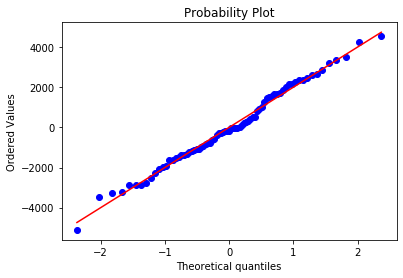

In [14]:
fig, ax = plt.subplots(figsize=(6,4))
_ = st.probplot(reg_Conso_residual['residual'], plot=ax, fit=True)

**Les résidus suivent une distribution normale.**

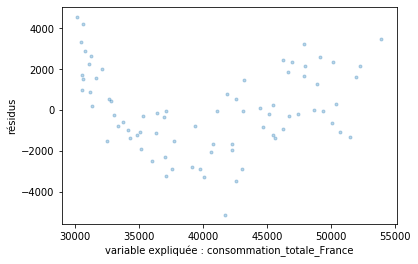

In [15]:
plt.plot(reg_Conso_residual['val_pred'], reg_Conso_residual['residual'], '.', alpha=0.3)
plt.xlabel('variable expliquée : consommation_totale_France')
_ = plt.ylabel('résidus')

**La variance des résidus est constante et les résidus suivent une distribution normale, il y a homoscédasticité : cette modélisation est fiable.**

In [16]:
print("Le coefficient de régression du DJU vaut",round(reg_Conso.params['DJU'],2),".")

Le coefficient de régression du DJU vaut 43.86 .


Quand le DJU augmente de 1, la consommation électrique augmente de 43,86.

**Il faut donc retrancher à chaque donnée de consommation totale mensuelle la quantité de DJU multipliée par le coefficient de régression.**

In [17]:
data['Correction_donnees_effet_temperature']=data['consommation_totale_France']-data['DJU']*reg_Conso.params['DJU']

data = data.set_index('Mois')

data.head(3)

,consommation_totale_France,DJU,Correction_donnees_effet_temperature
Mois,,,
2012-01-01,51086,454.5,31151.163241
2012-02-01,54476,555.6,30106.813414
2012-03-01,43156,334.9,28466.942067


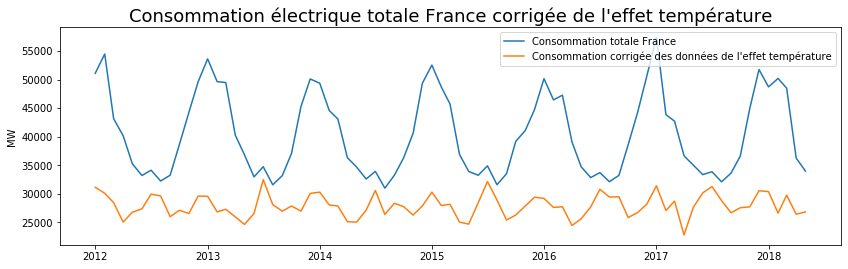

In [18]:
plt.figure(figsize=(14,4))

plt.plot(data['consommation_totale_France'], label='Consommation totale France')
plt.plot(data['Correction_donnees_effet_temperature'], label="Consommation corrigée des données de l'effet température")

plt.ylabel('MW')
plt.legend(loc='best')

plt.title("Consommation électrique totale France corrigée de l'effet température", fontsize=18)
plt.savefig('03.Correction_donnees_effet_temperature.png')

<a id="chapitre_2"></a>
## <span style="color: #030aa4">2. Désaisonnalisation de la consommation obtenue après correction, grâce aux moyennes mobiles</span>

La différence entre les valeurs minimales et maximales de la consommation corrigée des variations saisonnières est constante, le modèle est donc **additif**.

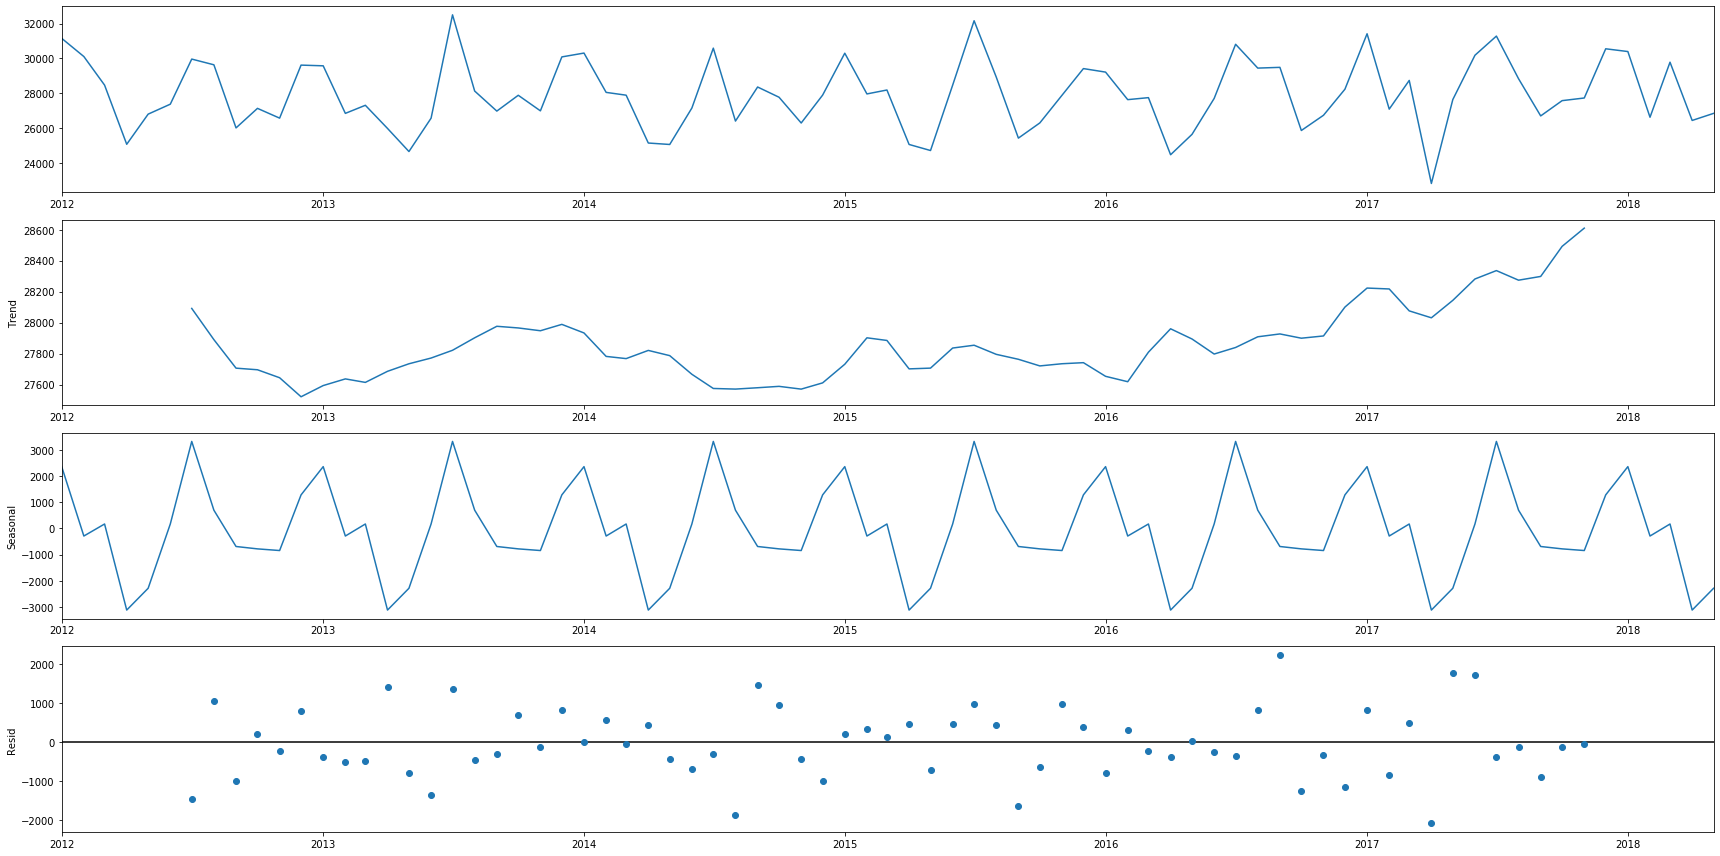

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

data_cvs=data.drop(columns=['consommation_totale_France','DJU'])

decomp_data = seasonal_decompose(data_cvs,  model='addititive')

plt.rc("figure", figsize=(24,12))
decomp_data.plot()

plt.savefig('04.Desaisonnalisation_moyennes_mobiles.png')
plt.show()

In [20]:
data['Conso_corrigee_desaisonnalisee']= data['Correction_donnees_effet_temperature'] - decomp_data.seasonal

data.head(3)

,consommation_totale_France,DJU,Correction_donnees_effet_temperature,Conso_corrigee_desaisonnalisee
Mois,,,,
2012-01-01,51086,454.5,31151.163241,28789.958694
2012-02-01,54476,555.6,30106.813414,30396.290933
2012-03-01,43156,334.9,28466.942067,28297.086814


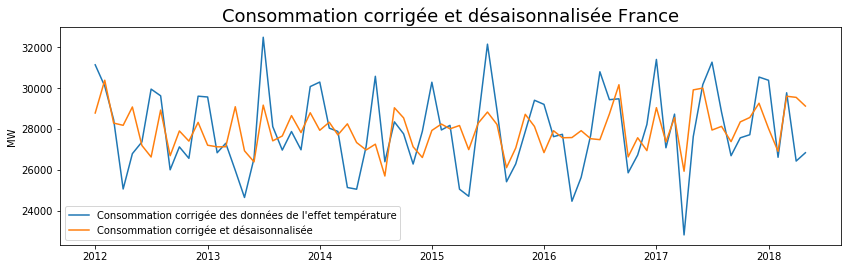

In [21]:
plt.figure(figsize=(14,4))

plt.plot(data['Correction_donnees_effet_temperature'], label="Consommation corrigée des données de l'effet température")
plt.plot(data['Conso_corrigee_desaisonnalisee'], label='Consommation corrigée et désaisonnalisée')

plt.ylabel('MW')
plt.legend(loc='best')

plt.title('Consommation corrigée et désaisonnalisée France', fontsize=18)
plt.savefig('05.Conso_corrigee_desaisonnalisee.png')

La consommation désaisonnalisée a une amplitude moins importante que la consommation corrigée des variations saisonnières.

<a id="chapitre_3"></a>
## <span style="color: #030aa4">3. Prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle</span>

**Méthode de Holt-Winters :**

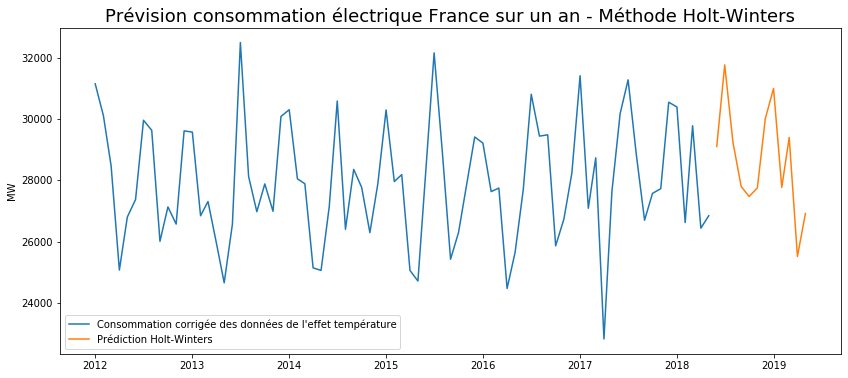

In [22]:
from statsmodels.tsa.api import ExponentialSmoothing

hw = ExponentialSmoothing(np.asarray(data['Correction_donnees_effet_temperature']), seasonal_periods=12, trend='mul', seasonal='mul').fit()
hw_pred = hw.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(data['Correction_donnees_effet_temperature'], label="Consommation corrigée des données de l'effet température")
plt.plot(pd.date_range(data.index[len(data)-1], periods=12, freq='M'), hw_pred, label='Prédiction Holt-Winters')
plt.legend()
plt.title('Prévision consommation électrique France sur un an - Méthode Holt-Winters', fontsize=18)
plt.ylabel('MW')
plt.savefig('06.Prevision_HW.png')
plt.show()

**Méthode SARIMA :**

#### Stationnarisation de la série

On désigne par $X_{t}$  la série 'consommation_totale_France'

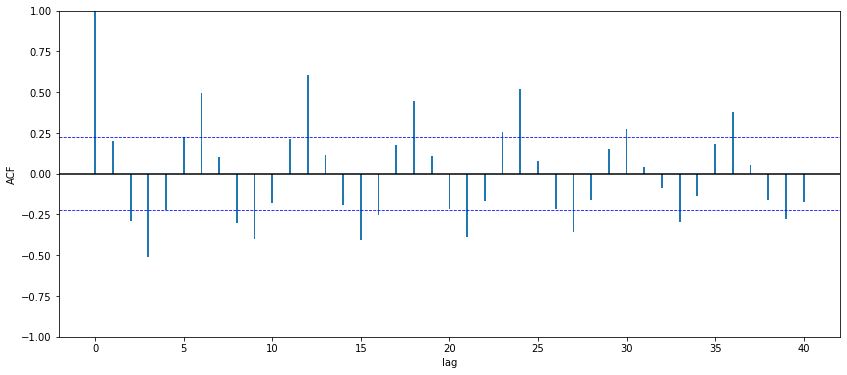

In [23]:
from statsmodels.tsa.stattools import acf, pacf
from functions import plot_sortie_acf

data_len = len(data['Correction_donnees_effet_temperature']) # variable nécessaire pour l'utilisation de plot_sortie_acf

plot_sortie_acf(acf(np.asarray(data['Correction_donnees_effet_temperature'])), data_len)

La sortie ACF présente une décroissance lente vers 0 pour les multiples de 12, ce qui traduit un problème de non-stationnarité. On effectue donc une différenciation $(I−B)$ .

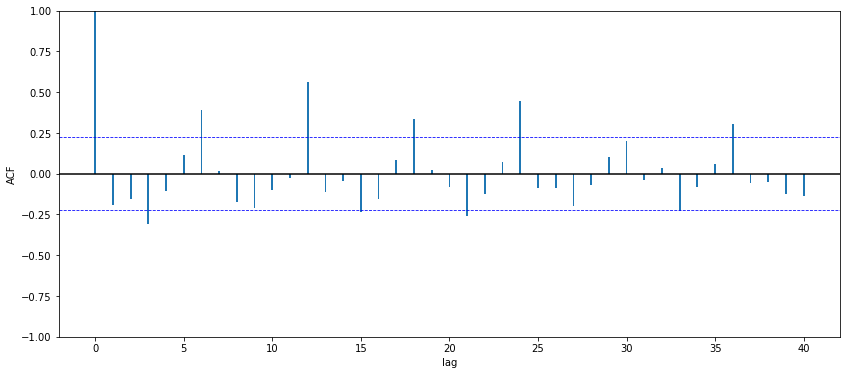

In [24]:
data_dif1 = data['Correction_donnees_effet_temperature'] - data['Correction_donnees_effet_temperature'].shift(1)

plot_sortie_acf(acf(np.asarray(data_dif1[1:])), data_len)

La sortie ACF de la série ainsi différenciée présente encore une décroissance lente vers 0 pour les multiples de 12. On effectue cette fois la différenciation $(I−B^{12})$ .

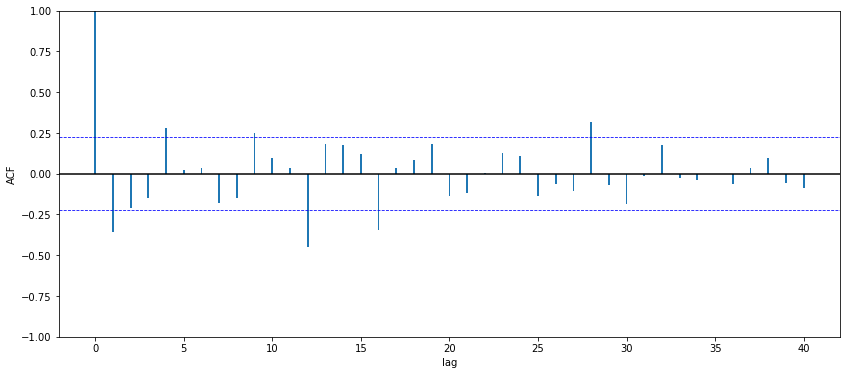

In [25]:
data_dif_1_12 = data_dif1 - data_dif1.shift(12)

plot_sortie_acf(acf(np.asarray(data_dif_1_12[13:])), data_len)

#### Identification, estimation et validation de modèles

On s’appuie sur les autocorrélogrammes simple et partiels estimés :

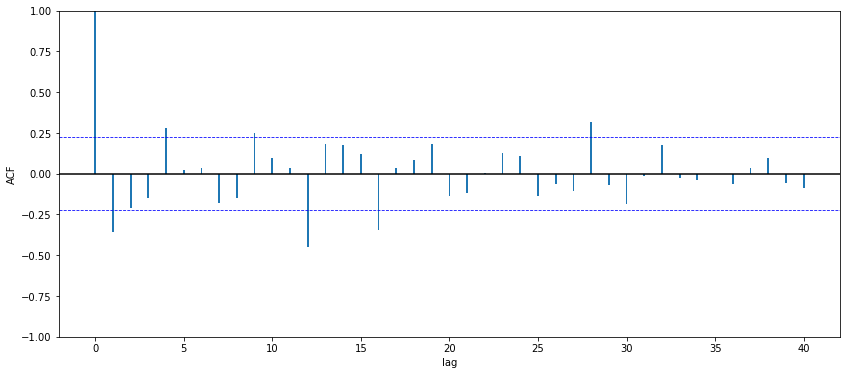

In [26]:
data_dif_1_12 = data_dif1 - data_dif1.shift(12)

plot_sortie_acf(acf(np.asarray(data_dif_1_12[13:])), data_len)

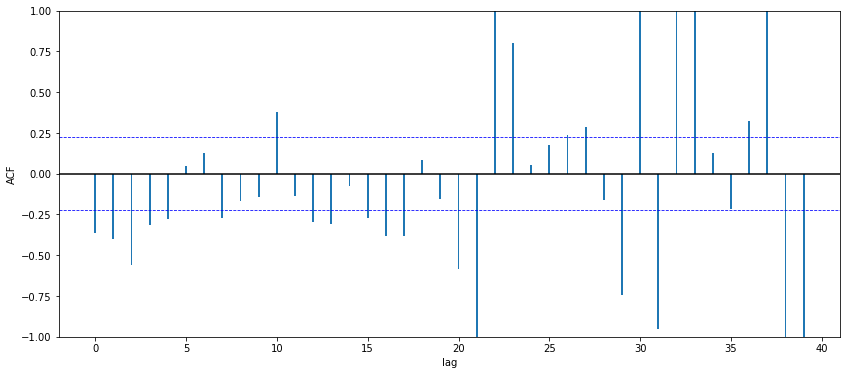

In [27]:
plot_sortie_acf(pacf(np.asarray(data_dif_1_12[13:])), data_len, pacf=True)

#### Modèle 1

On estime en premier lieu un modèle $SARIMA(1,1,1)(1,1,1)_{12}$ au vu des autocorrélogrammes empiriques simples et partiels. Ce modèle s’écrit :

$$(I−φ_{1}B)(I−φ′_{1}B^{12})(I−B)(I−B^{12})X_{t}=(I+θ_{1}B)(I+θ′_{1}B^{12})ε_{t} $$

In [28]:
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox

model = SARIMAX(np.asarray(data['Correction_donnees_effet_temperature']), order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   77
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -573.900
Date:                            Sun, 10 Jan 2021   AIC                           1157.800
Time:                                    08:43:43   BIC                           1168.595
Sample:                                         0   HQIC                          1162.053
                                             - 77                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5068      0.234      2.170      0.030       0.049       0.964
ma.L1         -0.6556      0.231   

Les tests de significativité des paramètres de prédiction à 12 mois (ar.S.L12 et ma.S.L12) et de blancheur du résidu sont validés au niveau 5%.

In [29]:
from scipy.stats import shapiro

shapiro(results.resid)

(0.5467074513435364, 4.753039663783244e-14)

Le test de normalité est également validé pour ce modèle.

#### Prévision à l’aide du modèle retenu

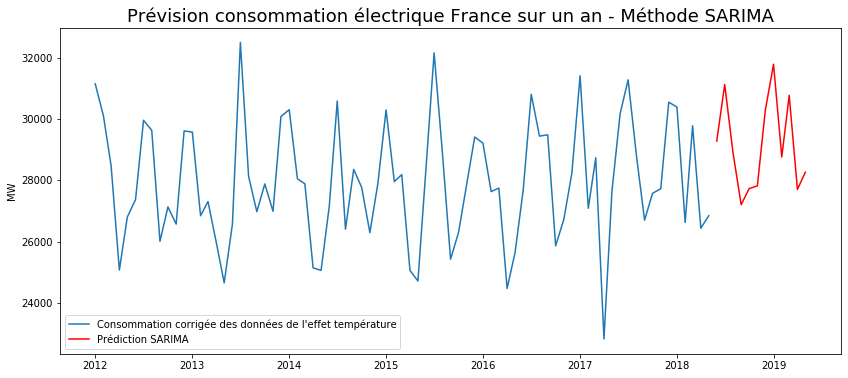

In [30]:
pred_model = results.get_forecast(12)
pred = pred_model.predicted_mean
pred_l = [elt[0] for elt in pred_model.conf_int(alpha=0.05)]
pred_u = [elt[1] for elt in pred_model.conf_int(alpha=0.05)]

plt.figure(figsize=(14,6))
plt.plot(data['Correction_donnees_effet_temperature'], label="Consommation corrigée des données de l'effet température")
plt.plot(pd.date_range(data.index[len(data)-1], periods=12, freq='M'), pred, color='r', label='Prédiction SARIMA')
#plt.plot(pd.date_range(data.index[len(data)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--')
#plt.plot(pd.date_range(data.index[len(data)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.title('Prévision consommation électrique France sur un an - Méthode SARIMA', fontsize=18)
plt.ylabel('MW')

plt.legend()
plt.savefig('07.Prevision_SARIMA.png')
plt.show()

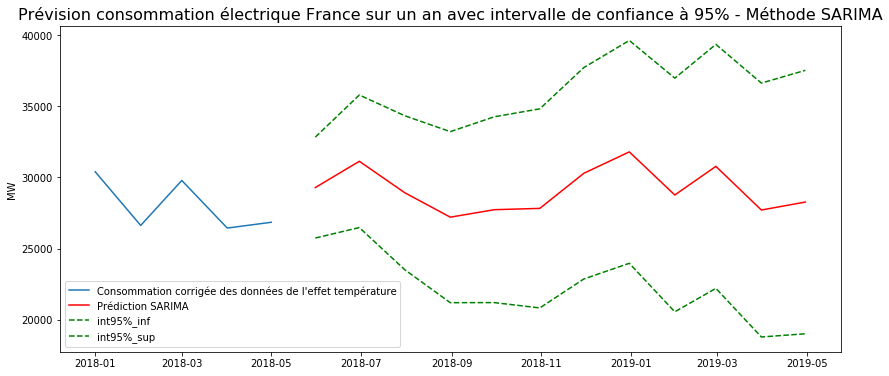

In [31]:
plt.figure(figsize=(14,6))
plt.plot(data['Correction_donnees_effet_temperature']['2018':], label="Consommation corrigée des données de l'effet température")
plt.plot(pd.date_range(data.index[len(data)-1], periods=12, freq='M'), pred, color='r', label='Prédiction SARIMA')
plt.plot(pd.date_range(data.index[len(data)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--', label='int95%_inf')
plt.plot(pd.date_range(data.index[len(data)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--', label='int95%_sup')
plt.legend()
plt.title('Prévision consommation électrique France sur un an avec intervalle de confiance à 95% - Méthode SARIMA', fontsize=16)
plt.ylabel('MW')
plt.savefig('08.Prevision_SARIMA_Int_95%.png')
plt.show()

#### Analyse à postériori

L'analyse à postériori permet de quantifier les écarts entre les prévisions et les réalisations, en tronquant la série d'un certain nombre de points.

In [32]:
data_tronc = data[:'2016']
data_a_prevoir = data['2017-01-01':'2017-12-01']
data_a_prevoir = data_a_prevoir.loc[:,'Correction_donnees_effet_temperature']

On vérifie que le modèle SARIMA sur la série tronquée est toujours validé.

In [33]:
model_tronc = SARIMAX(np.asarray(data_tronc['Correction_donnees_effet_temperature']), order=(1,1,1), seasonal_order=(1,1,1,12))
results_tronc = model_tronc.fit()
print(results_tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results_tronc.resid, lags=elt)[1].mean()))
    
shapiro(results_tronc.resid)

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -418.740
Date:                            Sun, 10 Jan 2021   AIC                            847.480
Time:                                    08:44:04   BIC                            856.731
Sample:                                         0   HQIC                           850.961
                                             - 60                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6006      0.256      2.345      0.019       0.099       1.103
ma.L1         -0.7005      0.249   

(0.5274031758308411, 1.309503178635596e-12)

Les tests de significativité des paramètres de prédiction à 12 mois (ar.S.L12 et ma.S.L12) et de blancheur du résidu sont validés au niveau 5%.

Le test de Shapiro est toujours validé.

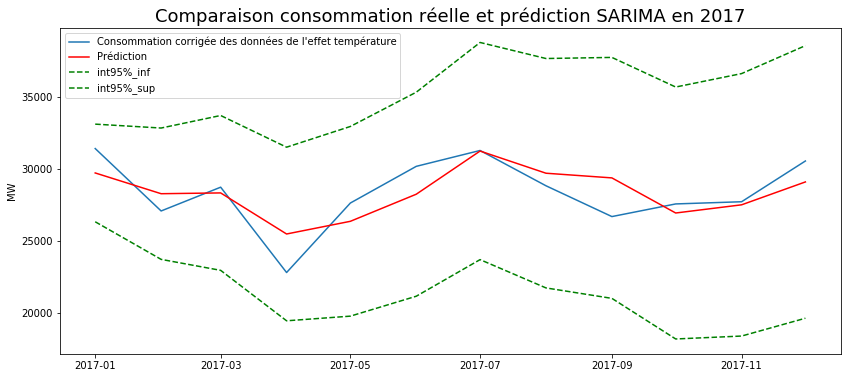

In [34]:
pred_model_tronc = results_tronc.get_forecast(12)
pred_tronc = pred_model_tronc.predicted_mean
pred_l_tronc = [elt[0] for elt in pred_model_tronc.conf_int(alpha=0.05)]
pred_u_tronc = [elt[1] for elt in pred_model_tronc.conf_int(alpha=0.05)]

plt.figure(figsize=(14,6))
plt.plot(data_a_prevoir, label="Consommation corrigée des données de l'effet température")
plt.plot(data_a_prevoir.index, pred_tronc, color='r', label='Prédiction')
plt.plot(data_a_prevoir.index, pred_l_tronc, color='g', linestyle='--', label='int95%_inf')
plt.plot(data_a_prevoir.index, pred_u_tronc, color='g', linestyle='--', label='int95%_sup')
plt.legend()
plt.ylabel('MW')
plt.title('Comparaison consommation réelle et prédiction SARIMA en 2017',fontsize=18)
plt.savefig('09.Analyse_posteriori.png')
plt.show()

Sur l'année 2017, la consommation corrigée des variations saisonnières et celle prédite par le modèle SARIMA à partir des données antérieures ont une variation très similaires. **Le modèle SARIMA est donc très fiable.**

#### Choix définitif du modèle retenu

Les prévisions obtenues avec les méthodes Holt-Winters et SARIMA sont différentes.

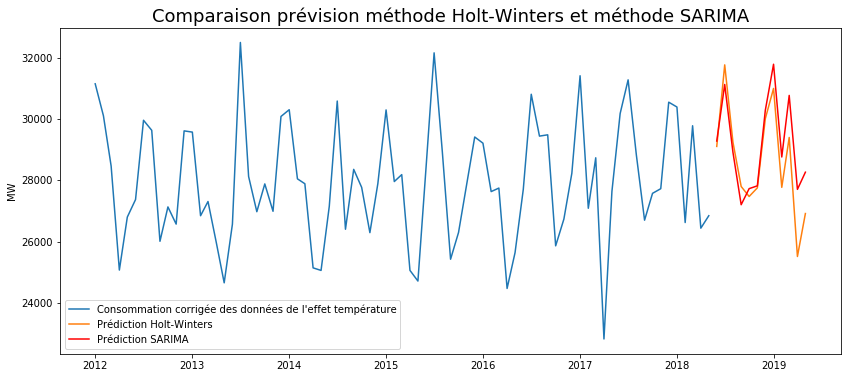

In [38]:
plt.figure(figsize=(14,6))
plt.plot(data['Correction_donnees_effet_temperature'], label="Consommation corrigée des données de l'effet température")
plt.plot(pd.date_range(data.index[len(data)-1], periods=12, freq='M'), hw_pred, label='Prédiction Holt-Winters')
plt.plot(pd.date_range(data.index[len(data)-1], periods=12, freq='M'), pred, color='r', label='Prédiction SARIMA')
plt.legend()
plt.title('Comparaison prévision méthode Holt-Winters et méthode SARIMA', fontsize=18)
plt.ylabel('MW')
plt.savefig('10.Comparaison_HW_SARIMA.png')
plt.show()

Il faut donc identifier le modèle le plus performant.

Le choix s'opère via des critères d'information basés sur l'information de Kullback, par exemple les critères d'Akaike (AIC) et de Schwartz (BIC) :

In [35]:
print("Critère AIC méthode Holt-Winters :",hw.aic)
print(" ")
print("Critère AIC méthode SARIMA :",results.aic)
print(" ")

if hw.aic<results.aic:
    print("Le critère AIC de la méthode Holt-Winters est le plus faible, c'est ce modèle que nous retenons.")
else :
    print("Le critère AIC de la méthode SARIMA est le plus faible, c'est ce modèle que nous retenons.")

print(" ")
print("-"*100)
print(" ")
print("Critère BIC méthode Holt-Winters :",hw.bic)
print(" ")
print("Critère BIC méthode SARIMA :",results.bic)
print(" ")

if hw.aic<results.aic:
    print("Le critère BIC de la méthode Holt-Winters est le plus faible, c'est ce modèle que nous retenons.")
else :
    print("Le critère BIC de la méthode SARIMA est le plus faible, c'est ce modèle que nous retenons.")

Critère AIC méthode Holt-Winters : 1114.8493831529838
 
Critère AIC méthode SARIMA : 1157.8001227139798
 
Le critère AIC de la méthode Holt-Winters est le plus faible, c'est ce modèle que nous retenons.
 
----------------------------------------------------------------------------------------------------
 
Critère BIC méthode Holt-Winters : 1152.3502699026428
 
Critère BIC méthode SARIMA : 1168.5945381307781
 
Le critère BIC de la méthode Holt-Winters est le plus faible, c'est ce modèle que nous retenons.


**Selon les critères BIC et AIC, la méthode Holt-Winters est la plus fiable.**

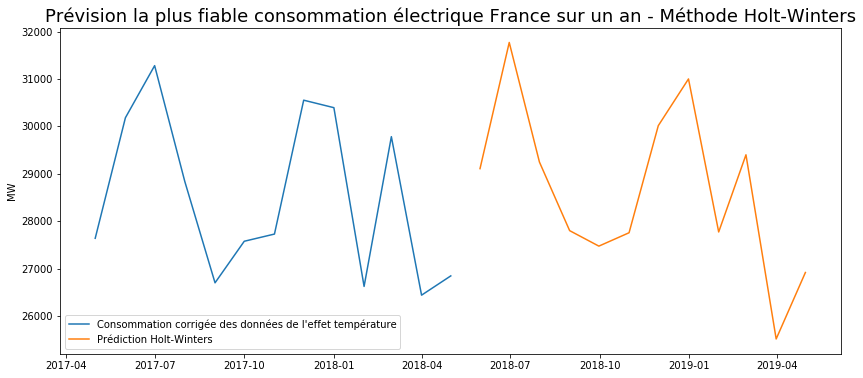

In [40]:
plt.figure(figsize=(14,6))
plt.plot(data['Correction_donnees_effet_temperature'][64:], label="Consommation corrigée des données de l'effet température")
plt.plot(pd.date_range(data.index[len(data)-1], periods=12, freq='M'), hw_pred, label='Prédiction Holt-Winters')
plt.legend()
plt.title('Prévision la plus fiable consommation électrique France sur un an - Méthode Holt-Winters', fontsize=18)
plt.ylabel('MW')
plt.savefig('11.Conclusion.png')
plt.show()